In [1]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import configparser
import numpy as np
import models.siamese as siamese
import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve


In [2]:
config = configparser.ConfigParser()
config.read(os.path.join("config", "look.ini"))
config_model_dict = {k.upper(): v for k, v in config["SIAMESE"].items()}
config_data_dict = {k.upper(): v for k, v in config["DATA"].items()}

In [3]:
crop_size = int(config_data_dict["CROP_SIZE"])
def map_func(example_serialized):
    print(example_serialized)  
    image_anchor = example_serialized['anchor']
    image_anchor = tf.image.resize_with_pad(image_anchor, 256, 256)
    image_anchor = tf.image.random_crop(image_anchor, size = [crop_size, crop_size, 3])
    image_anchor = tf.cast(image_anchor, tf.float32)

    image_positive = example_serialized['positive']    
    image_positive = tf.image.resize_with_pad(image_positive, 256, 256)
    image_positive = tf.image.random_crop(image_positive, size = [crop_size, crop_size, 3])
    image_positive = tf.cast(image_positive, tf.float32)

    image_negative = example_serialized['negative']
    image_negative = tf.image.resize_with_pad(image_negative, 256, 256)
    image_negative = tf.image.random_crop(image_negative, size = [crop_size, crop_size, 3])
    image_negative = tf.cast(image_negative, tf.float32)
    return image_anchor, image_positive, image_negative

In [4]:
DIM = int(config_data_dict["CROP_SIZE"])
def triplet_loss(alpha):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:,:DIM], y_pred[:,DIM:2*DIM], y_pred[:,2*DIM:]
        positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
        negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
        return tf.maximum(positive_dist - negative_dist + alpha, 0.)
    return loss


In [5]:
train_ds, valid_known_ds, valid_unknown_ds = tfds.load(
    "sketchy", split=["train", "validation_known", "validation_unknown"]
)


2023-09-30 06:01:57.068476: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-09-30 06:01:57.068498: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-09-30 06:01:57.068507: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-09-30 06:01:57.068538: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-30 06:01:57.068555: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
AUTO = tf.data.AUTOTUNE
train_ds = (
    train_ds
    .shuffle(1024)
    .map(map_func, num_parallel_calls=AUTO)
    .batch(int(config_model_dict["BATCH_SIZE"]))
    .prefetch(AUTO)
)

{'anchor': <tf.Tensor 'args_0:0' shape=(256, 256, 3) dtype=uint8>, 'label': <tf.Tensor 'args_1:0' shape=() dtype=int64>, 'negative': <tf.Tensor 'args_2:0' shape=(256, 256, 3) dtype=uint8>, 'positive': <tf.Tensor 'args_3:0' shape=(256, 256, 3) dtype=uint8>}


In [7]:
model = siamese.Siamese(config_model_dict, config_data_dict)
optimizer = tf.keras.optimizers.legacy.SGD(momentum=0.9)
model.compile(optimizer=optimizer, loss=triplet_loss(config_model_dict["ALPHA"]))
model.build()

if (os.path.exists("model.weights.h5")):
  model.load_weights("model.weights.h5")
  history_dict = json.load(open("history.json", "r"))
else:
  history = model.fit(train_ds, epochs=int(config_model_dict["EPOCHS"]))
  model.save_weights("model.weights.h5")
  history_dict = history.history
  with open("history.json", "w") as f:
      json.dump(history_dict, f)


Epoch 1/25


2023-09-30 06:02:03.481485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1539/1539 [==============================] - 1526s 967ms/step - loss: 0.9942 - dist_pos: 0.0696 - dist_neg: 0.0760
Epoch 2/25
1539/1539 [==============================] - 1455s 945ms/step - loss: 0.8940 - dist_pos: 0.4076 - dist_neg: 0.5311
Epoch 3/25
1539/1539 [==============================] - 1453s 944ms/step - loss: 0.8093 - dist_pos: 0.5947 - dist_neg: 0.8179
Epoch 4/25
1539/1539 [==============================] - 1453s 944ms/step - loss: 0.7598 - dist_pos: 0.6706 - dist_neg: 0.9505
Epoch 5/25
1539/1539 [==============================] - 1453s 944ms/step - loss: 0.7247 - dist_pos: 0.7074 - dist_neg: 1.0271
Epoch 6/25
1539/1539 [==============================] - 1451s 942ms/step - loss: 0.6970 - dist_pos: 0.7256 - dist_neg: 1.0772
Epoch 7/25
1539/1539 [==============================] - 1451s 943ms/step - loss: 0.6734 - dist_pos: 0.7336 - dist_neg: 1.1123
Epoch 8/25
1539/1539 [==============================] - 1451s 942ms/step - loss: 0.6516 - dist_pos: 0.7359 - dist_neg: 1.1398
Epo

# Graphs and Metrics

In [8]:
encoder = model.get_encoder()
# Step 1: Generate Embeddings

# Sketch embeddings and labels
sketch_embeddings = []
sketch_labels = []

# Image embeddings and labels
image_embeddings = []
image_labels = []

# Loop through the validation dataset and generate embeddings
for example in tfds.as_numpy(valid_unknown_ds):  # Adjust based on actual use case
    sketch = example['anchor']
    image = example['positive']
    label = example['label']
    
    sketch_embeddings.append(encoder.predict(np.expand_dims(sketch, axis=0))[0])
    image_embeddings.append(encoder.predict(np.expand_dims(image, axis=0))[0])
    
    sketch_labels.append(label)
    image_labels.append(label)

# Convert to numpy arrays for easier manipulation
sketch_embeddings = np.array(sketch_embeddings)
image_embeddings = np.array(image_embeddings)
sketch_labels = np.array(sketch_labels)
image_labels = np.array(image_labels)

1/1 [==============================] - 0s 24ms/step


In [9]:
all_predictions = []
all_ground_truth = []

# Loop through all sketches and calculate predictions and ground truth
for idx, query_embedding in enumerate(sketch_embeddings):
    # Calculate distances to all image embeddings
    distances = np.linalg.norm(image_embeddings - query_embedding, axis=1)
    
    # Since lower distance means higher similarity, use negative distance as prediction
    predictions = -distances
    
    # Determine ground truth: 1 if image label matches sketch label, 0 otherwise
    ground_truth = (image_labels == sketch_labels[idx]).astype(int)
    
    # Add to overall lists
    all_predictions.append(predictions)
    all_ground_truth.append(ground_truth)


In [10]:
sketchy_classes = json.load(open(os.path.join("tensorflow_datasets", "sketchy", "sketchy_classes.json"), "r"))
sketchy_classes = {int(v): k for k, v in sketchy_classes.items()}

## Total mAP and mAP per class

In [11]:
def calculate_average_precision(predictions, ground_truth):
    """
    Calculate the Average Precision (AP) for a single class.
    
    Parameters:
    - predictions: List of predicted confidences
    - ground_truth: List of ground truth labels
    
    Returns:
    - average_precision: The average precision of the class
    """
    # Sort predictions and ground_truth based on confidence scores
    sorted_indices = np.argsort(predictions)[::-1]
    sorted_ground_truth = ground_truth[sorted_indices]
    
    # Compute Precision-Recall curve
    precisions = []
    recalls = []
    tp = 0  # true positive
    fp = 0  # false positive
    
    for i, label in enumerate(sorted_ground_truth):
        if label == 1:  # positive
            tp += 1
        else:  # negative
            fp += 1
        precision = tp / (tp + fp)
        recall = tp / np.sum(ground_truth)  # assuming binary classification
        precisions.append(precision)
        recalls.append(recall)
    
    # Compute Average Precision (AP)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    average_precision = np.sum(precisions * np.gradient(recalls))
    
    return average_precision


In [12]:
# Calculate mAP across all queries
all_average_precisions = [
    calculate_average_precision(pred, gt)
    for pred, gt in zip(all_predictions, all_ground_truth)
]
mean_average_precision = np.mean(all_average_precisions)
print(f"mAP: {mean_average_precision}")

# mAP for each class
for i, ap in enumerate(all_average_precisions):
    # get class name from label
    class_name = sketchy_classes[sketch_labels[i]]
    print(f"AP for class {class_name}: {ap}")


mAP: 0.05362507362889103
AP for class airplane: 0.2228898936385679
AP for class blimp: 0.08360316326381133
AP for class bench: 0.04194469819252612
AP for class airplane: 0.21764119922007494
AP for class seagull: 0.04358166571693929
AP for class teapot: 0.027577560380496618
AP for class bench: 0.043791347905579994
AP for class teapot: 0.028287850679647987
AP for class rhinoceros: 0.039762940163488254
AP for class sheep: 0.03383023011323982
AP for class hedgehog: 0.051573208716339074
AP for class scissors: 0.03968445178517957
AP for class seal: 0.06238280959761075
AP for class bench: 0.04438969103028695
AP for class piano: 0.021672768536003154
AP for class apple: 0.021133068479273112
AP for class scissors: 0.04007070819544334
AP for class scissors: 0.039772463462397406
AP for class airplane: 0.184045105993151
AP for class windmill: 0.07602153160687344
AP for class blimp: 0.08365927184687101
AP for class rhinoceros: 0.039035335686629466
AP for class hedgehog: 0.06000208708792057
AP for cl

## Total Recall@1 and Recall@1 per class

In [13]:
def calculate_recall_at_1(query_embedding, search_space_embeddings, query_label, search_space_labels):
    """
    Calculate Recall@1.
    
    Parameters:
    - query_embedding: The embedding of the query item (sketch)
    - search_space_embeddings: The embeddings of items to search through (images)
    - query_label: The class label of the query item
    - search_space_labels: The class labels of the search items
    
    Returns:
    - recall_at_1: Recall@1 score
    """
    # Calculate distances between query and all items in search space
    distances = np.linalg.norm(search_space_embeddings - query_embedding, axis=1)
    
    # Find the index of the nearest neighbor
    nn_index = np.argmin(distances)
    
    # Check if the nearest neighbor has the same label as the query
    return int(query_label == search_space_labels[nn_index])


In [14]:
all_recall_at_1 = []

# Loop through all sketch embeddings and labels
for query_embedding, query_label in zip(sketch_embeddings, sketch_labels):
    
    # Calculate Recall@1 for the current query
    recall_at_1 = calculate_recall_at_1(query_embedding, image_embeddings, query_label, image_labels)
    
    # Append to the overall list
    all_recall_at_1.append(recall_at_1)

# Calculate the average Recall@1 across all queries
average_recall_at_1 = np.mean(all_recall_at_1)

print(f"Average Recall@1: {average_recall_at_1:.2%}")

# Recall@1 for each class
for i, recall_at_1 in enumerate(all_recall_at_1):
    # get class name from label
    class_name = sketchy_classes[sketch_labels[i]]
    print(f"Recall@1 for class {class_name}: {recall_at_1:.2%}")


Average Recall@1: 4.18%
Recall@1 for class airplane: 100.00%
Recall@1 for class blimp: 0.00%
Recall@1 for class bench: 0.00%
Recall@1 for class airplane: 100.00%
Recall@1 for class seagull: 0.00%
Recall@1 for class teapot: 0.00%
Recall@1 for class bench: 0.00%
Recall@1 for class teapot: 0.00%
Recall@1 for class rhinoceros: 0.00%
Recall@1 for class sheep: 0.00%
Recall@1 for class hedgehog: 0.00%
Recall@1 for class scissors: 0.00%
Recall@1 for class seal: 0.00%
Recall@1 for class bench: 0.00%
Recall@1 for class piano: 0.00%
Recall@1 for class apple: 0.00%
Recall@1 for class scissors: 0.00%
Recall@1 for class scissors: 0.00%
Recall@1 for class airplane: 0.00%
Recall@1 for class windmill: 0.00%
Recall@1 for class blimp: 0.00%
Recall@1 for class rhinoceros: 0.00%
Recall@1 for class hedgehog: 0.00%
Recall@1 for class airplane: 0.00%
Recall@1 for class pizza: 0.00%
Recall@1 for class apple: 0.00%
Recall@1 for class songbird: 0.00%
Recall@1 for class bell: 0.00%
Recall@1 for class songbird: 0.

## Recall-Precision Curve

In [15]:
def plot_precision_recall_curve(predictions, ground_truth):
    """
    Plot the Precision-Recall curve.
    
    Parameters:
    - predictions: Predicted confidence scores
    - ground_truth: Ground truth labels
    """
    precision, recall, _ = precision_recall_curve(ground_truth, predictions)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()


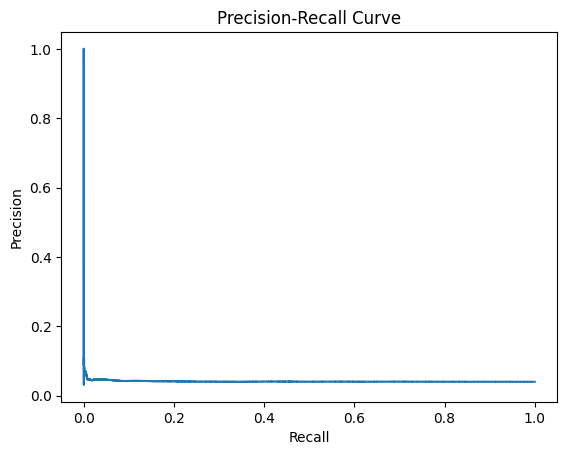

In [16]:
all_predictions = []
all_ground_truth = []

# Loop through all sketches and calculate predictions and ground truth
for idx, query_embedding in enumerate(sketch_embeddings):
    # Calculate distances to all image embeddings
    distances = np.linalg.norm(image_embeddings - query_embedding, axis=1)
    
    # Since lower distance means higher similarity, use negative distance as prediction
    predictions = -distances
    
    # Determine ground truth: 1 if image label matches sketch label, 0 otherwise
    ground_truth = (image_labels == sketch_labels[idx]).astype(int)
    
    # Add to overall lists
    all_predictions.extend(predictions)
    all_ground_truth.extend(ground_truth)

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_ground_truth = np.array(all_ground_truth)

# Plot Precision-Recall Curve
plot_precision_recall_curve(all_predictions, all_ground_truth)

## Examples of predictions

In [17]:
def display_examples(model, query_sketch, search_space_images, num_examples=10):
    """
    Display example results.
    
    Parameters:
    - model: The trained model to generate embeddings
    - query_sketch: The sketch to use as a query (should be preprocessed in the same way as training data)
    - search_space_images: The images to search through (should be a tf.data.Dataset object)
    - num_examples: Number of examples to show
    
    Note: Adjust preprocessing and model prediction code as per your implementation.
    """
    query_embedding = model.predict(np.expand_dims(query_sketch, axis=0), verbose=0)[0]

    image_embeddings = []
    image_labels = []
    actual_images = []  # Store the actual images for later display

    for example in tfds.as_numpy(search_space_images.take(1000)):
        image = example['positive']
        label = example['label']
        image_embeddings.append(model.predict(np.expand_dims(image, axis=0), verbose=0)[0])
        image_labels.append(label)
        actual_images.append(image)  # Store the actual image

    distances = np.linalg.norm(image_embeddings - query_embedding, axis=1)
    closest_indices = np.argsort(distances)[:num_examples]

    plt.figure(figsize=(20, 4))
    plt.subplot(1, num_examples + 1, 1)
    plt.imshow(query_sketch)
    plt.title("Query")

    for i, idx in enumerate(closest_indices):
        plt.subplot(1, num_examples + 1, i + 2)
        plt.imshow(actual_images[idx])  # Use the stored actual images
        plt.title(f"Rank {i + 1}\nLabel: {image_labels[idx]}")

    plt.show()


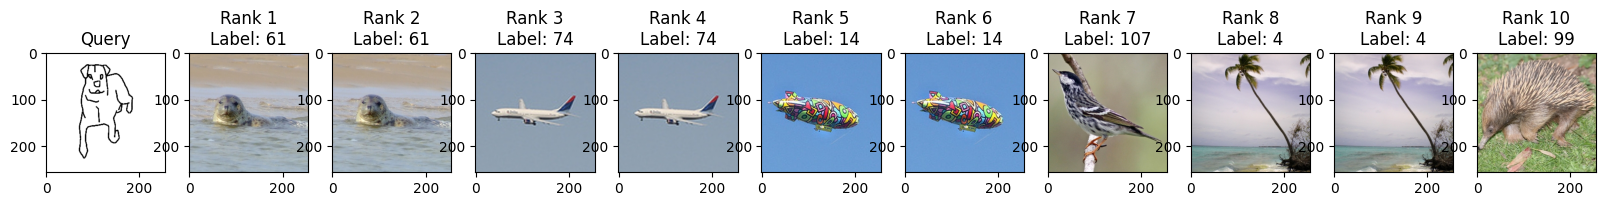

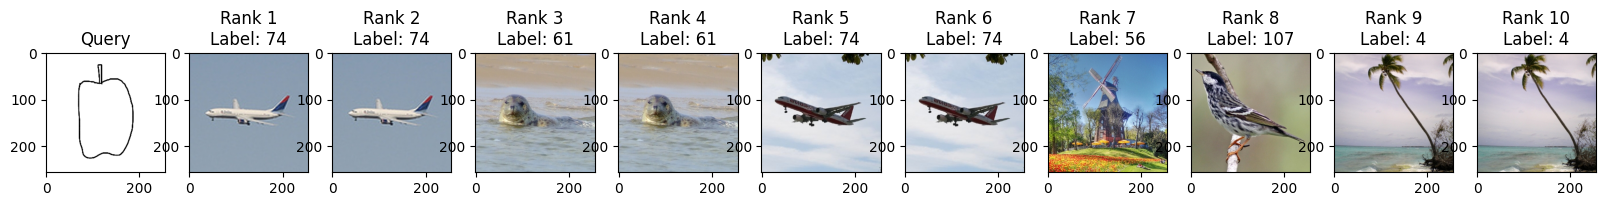

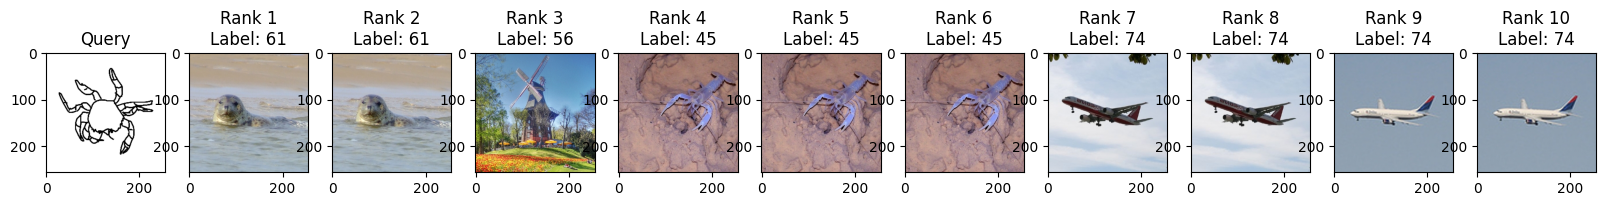

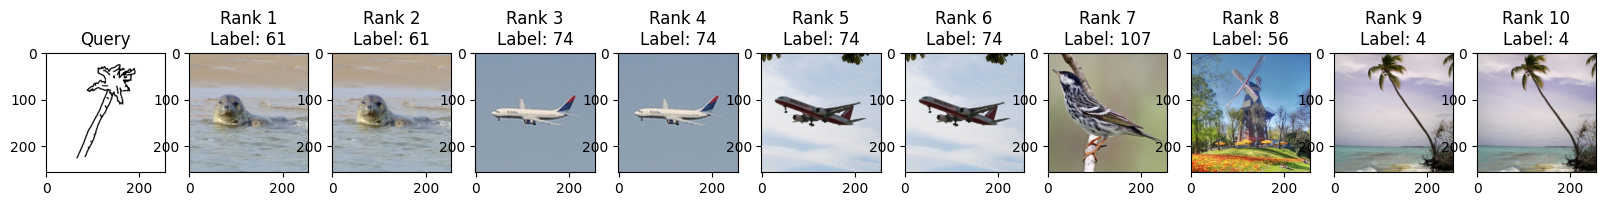

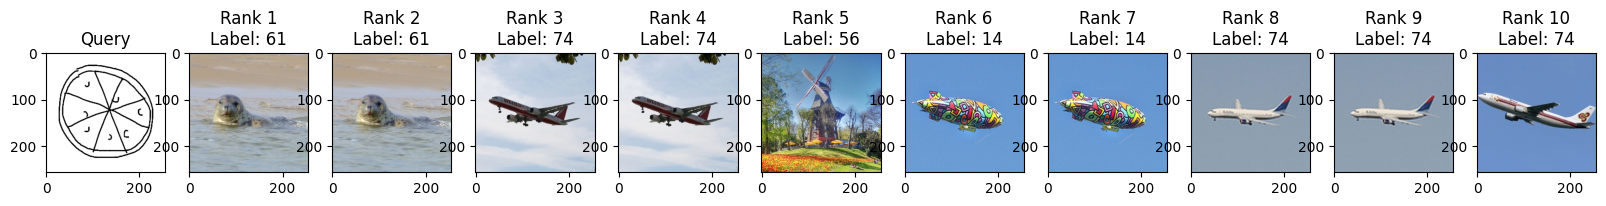

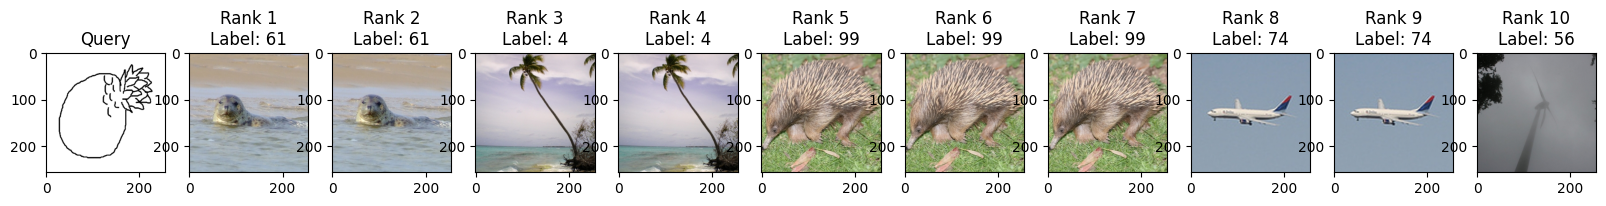

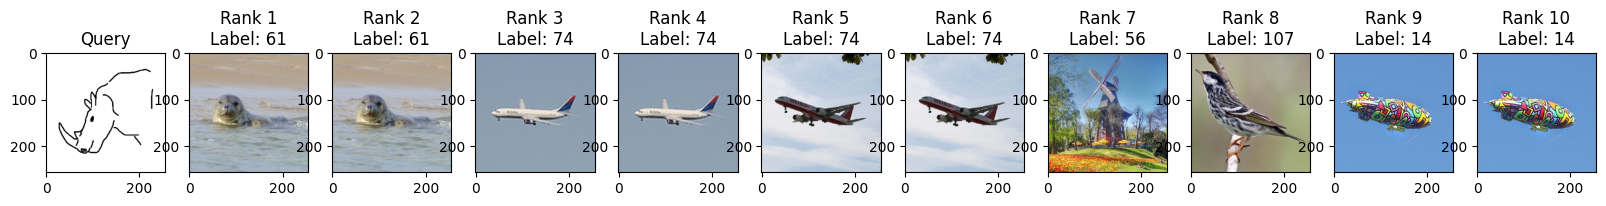

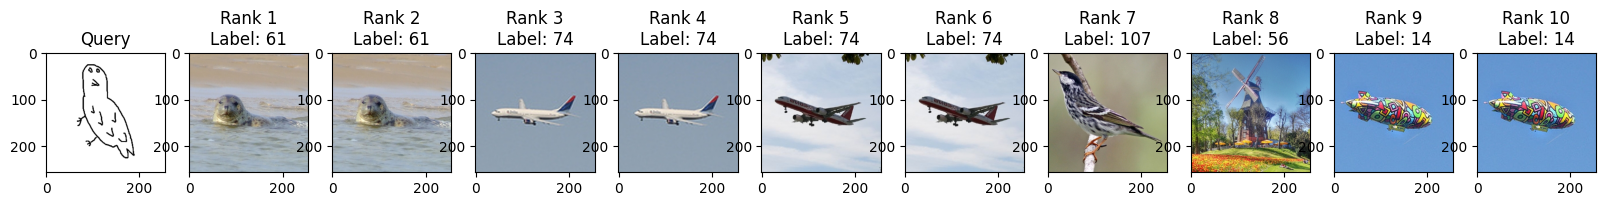

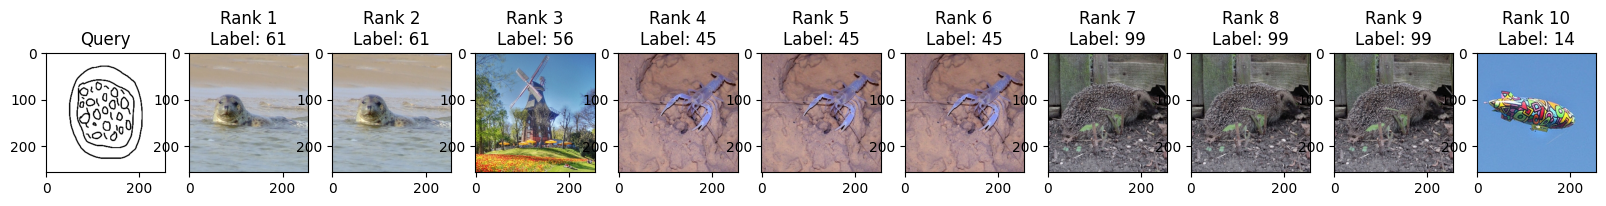

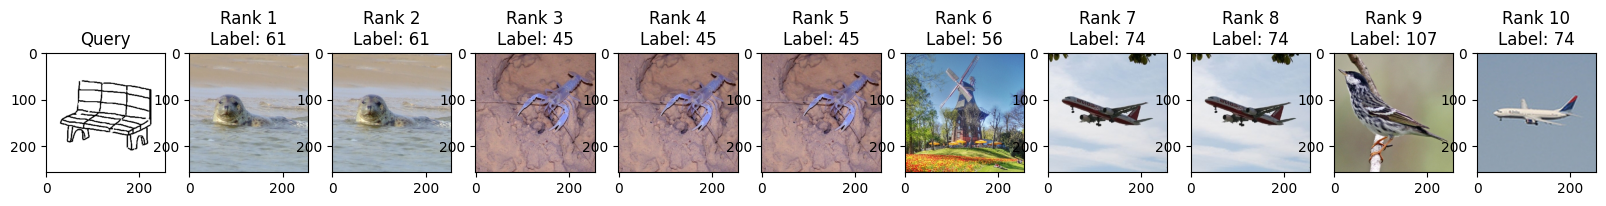

In [18]:
num_sketches = 10

for _ in range(num_sketches):
    query_idx = np.random.randint(len(sketch_embeddings))
    for i, example in enumerate(valid_unknown_ds):
        if i == query_idx:
            query_sketch = example['anchor']
            break
    display_examples(encoder, query_sketch, valid_unknown_ds, num_examples=10)
